- A common feature of learning models is recurrence -- where the outputs of the model are related back to the model as inputs. Here, we're particularly interested in implementing and understanding the MINERVA 2 model's recurrence mechanism. In MINERVA, recursion enables memory systems to confine activation to a particular subset of traces containing a particular pattern of weights. To study the efficacy of this mechanism, we'll document the model's capacity to account for tasks used to study rest-dependent memory consolidation. According to an account proposed by Foldes (2021), people replay memories of study events during rest, leading to improvements in recall performance. MINERVA 2's recurrence mechanism is thought to be a good model of this sort of replay. We'll present a specification of the model and apply it to simulate benchmark rest-dependent memory consolidation effects in three tasks: transitive inference, paired associate learning, and serial reaction time. 

- From here, will give the mechanism a little more scrutiny. If we take as a given that the main effect of recurrence of recurrence in MINERVA 2 is to confine echo content to a particular subset of traces, then what distinguishes it from, say, applying an higher exponent during probing to each trace's activation before aggregating traces to form an echo? By tradition, this exponent is held at 3, but higher values similarly concentrate activation to traces most similar to the item probe and is less computationally taxing. We'll explore whether increasing MINERVA II's nonlinear scaling parameter transforms retrieved model representations in the same way recurrence does or not.

- The context maintenance and retrieval model of free recall (CMR; Polyn & Kahana, 2009) includes its own nonlinear activation scaling parameter. But if we do find that recurrence in MINERVA II has different effects on retrieval than increased nonlinear activation scaling, we'll next explore the consequences of introducing MINERVA-style recurrence into an instance-based implementation of the model, identifying the kinds of predictions that the mechanism corresponds to. We'll then relate these insights back to the rest-dependent memory consolidation tasks initially modeled.

## The MINERVA 2 Model

![Figure 2 from Hintzman, 1986.](Hintzman1986fig2.png)

We start by specifying an `ExemplarModel` class that implements the instance-based model architecture. Under the architecture, every `experience` is represented as a vector - an ordered list of feature values along many dimensions. A record of each experience - called a `trace` is stored as a new, separate row in a m x n `memory` matrix where rows correspond to memory traces and columns correspond to feature dimensions.

To retrieve information from memory, a feature vector can be presented as a `probe`. The probe activates all traces in memory in parallel. Each trace's `activation` is a cubed function of its cosine `similarity` to the probe: $$A(i) = S(i)^3$$ The sum of these traces weighted by their activation represents an `echo` summarizing the memory system's response to the probe. The content and intensity of this echo can serve downstream behavior such as recognition, word sense disambiguation, and even free recall. For example, to compare memory representations associated with two probes, the model can compute the resemblance (cosine similarity) between the echoes associated with probes A and B.

We will simulate the recurrence mechanism within this model by iteratively conversion of retrieved echo representations into new probe representations. For most experiments, though we're studying recurrence as a mechanism of memory consolidation, we'll generally directly compare recurrently-retrieved representations

To represent items, we'll follow the lead of Kelly, Mewhort, & West (2017). We'll use vectors of 64 dimensions whose values are randomly sampled from a normal distribution. And to represent co-encoding of items, we'll use a sum of corresponding item vectors.

In [5]:
#| code-summary: code -- an `ExemplarModel` class that implements the instance-based model architecture

import numpy as np
from numpy.linalg import norm


class ExemplarModel:
    """
    The basic exemplar model of memory as originated by Hintzman (1984, 1986, 1988) in MINERVA 2.

    Under the architecture, every `experience` is represented as a vector - an ordered list of
    feature values along many dimensions. A record of each experience - called a `trace` is stored
    as a new, separate row in a m x n `memory` matrix where rows correspond to memory traces and
    columns correspond to feature dimensions.

    To retrieve information from memory, a feature vector can be presented as a `probe`. The probe
    activates all traces in memory in parallel. Each trace's `activation` is a cubed function of
    its `similarity` to the probe. The sum of these traces weighted by their activation represents
    an `echo` summarizing the memory system's response to the probe. The content and intensity of
    this echo can serve downstream behavior such as recognition, word sense disambiguation, and
    even free recall. For example, to compare memory representations associated with two probes,
    the model can compute the resemblance (cosine similarity) between the echoes associated with
    probes A and B.

    Attributes:
    - memory: array where rows correspond to accumulated memory traces and columns correspond to
    feature dims
    """

    def __init__(self, experiences=None):
        """
        Inits exemplar model with initial set of experiences in memory (if any).
        """
        self.memory = None
        if experiences is not None:
            self.experience(experiences)

    def experience(self, experiences):
        """
        Adds new experience(s) to model memory, represented as new row(s) in the model's memory
        array.
        """
        self.memory = (
            np.vstack((self.memory, np.array(experiences)))
            if self.memory
            else np.array(experiences)
        )

    def probe(self, probe):
        """
        Presents a cue to memory system, fetching echo reflecting its pattern of activation across
        traces. The probe activates all traces in memory in parallel. Each trace's `activation` is
        a cubed function of its `similarity` to the probe. The sum of these traces weighted by
        their activation is an `echo` summarizing the memory system's response to the probe.

        Raises error if no traces are yet stored in memory.
        """
        # computes and cubes similarity value to find activation for each trace in memory
        activation = np.power(
            np.sum(self.memory * probe, axis=1)
            / (norm(self.memory, axis=1) * norm(probe)),
            3,
        )

        # multiply each trace by its associated activation
        # and take a column-wise sum to retrieve echo
        echo = np.sum((self.memory.T * activation).T, axis=0)
        return echo

    def compare_probes(self, first_probe, second_probe):
        """
        Compute the resemblance (cosine similarity) between the echoes associated with probes A
        and B.

        Raises error if no traces are yet stored in memory.
        """
        echoes = self.probe(first_probe), self.probe(second_probe)
        return np.sum(echoes[0] * echoes[1]) / (norm(echoes[0]) * norm(echoes[1]))


## The Transitive Inference Task

![Figure 1 from Ellenbogen, 2007.](ellenbogen2007figure1.png)

In the transitive inference task, subjects start with a phase of premise pair learning. They may study six pairs of novel visual patterns, with each pair randomly assigned to a particular hierarchical order. Participants learned these individual premise pairs (represented schematically as A>B, B>C, C>D, D>E, and E>F to a high degree of proficiency and were subsequently tested after the respective delay periods. Participants were instructed that they were learning individual comparisons (e.g., B>C) but were not informed of the hierarchical structure (A>B>C>D>E>F) from which inferences could be made (e.g., B>D and C>E -- inference pairs with "1 degree of separation" -- or B>E, a pair with "2 degrees of separation"). After the time delay (20m, 12hrs, or 24hrs), premise pair performance was tested (e.g., B?C) together with novel item combinations never learned (e.g., B?E), thereby probing inferential ability.

Participants were instructed that two visual objects would appear side by side on the screen, one at a time. On each trial, participants saw one of the five premise pairs (either A-B, B-C, C-D, D-E, or E-F). Subjects were instructed to select the correct item, at first by trial and error, but that with practice, they may be able to learn which of the two object items was correct, based on cued feedback. Participants were trained on the premise pairs until they reached a performance criterion. After delay, they did the same task but without any feedback.

To model this task, we encode paired items as a sum of corresponding item representations, weighting this sum to prioritize the reinforced / hierarchically higher item. Then to measure recall upon presentation of a premise pair, we construct an unweighted sum of corresponding item representations and use it as a probe to the model. Recall is successful if the retrieved echo is more similar to the hierarchically higher item than to the hierarchically lower item in the probe.

In [6]:
#| code-summary: code -- parameters and dependencies for transitive inference experiment

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

## recursion iterations to try out before doing similarity test
recursion_iteration_counts = [0, 1, 10]

## number of unique experiments to simulate
experiment_count = 1000

## reinforced item is `reinforcement_scale` times more prominent in encoded trace than distractor
reinforcement_scale = 3

## item features including number of items, dimensionality, mean and std of sampled feature values
number_of_items = 5
item_dimensionality = 64
item_mean = 0
item_standard_deviation = 1

## trial features including number of blocks
# in a block, participants encoded each premise pair twice
# on average participants practiced ~13 blocks before obtaining threshold (>80%) decision accuracy
block_count = 13
repeats_per_block = 2

## degrees of separation to consider
# in Ellenbogen et al, 2007, researchers only go up to 2
considered_degrees_of_separation = [0, 1, 2]

In [7]:
#| code-summary: code -- transitive inference simulation experiment

# results are binned by recursion_iteration_counts and considered_degree_of_separation
correct = np.zeros((len(recursion_iteration_counts), len(considered_degrees_of_separation)))
total = correct.copy()

for recurrence_index, recurrence_iterations in enumerate(recursion_iteration_counts):

    for experiment in range(experiment_count):

        # generate item representations for this experiment
        items = np.random.normal(
            item_mean, item_standard_deviation, (number_of_items, item_dimensionality)
        )

        # initialize model memory based on specified block_count, item_count, and repeats_per_block
        experiences = []
        for block in range(block_count):
            for item_index in range(len(items) - 1):
                for repeat_iteration in range(repeats_per_block):

                    # study event is weighted composite of item i and item i+1
                    experiences.append(
                        (reinforcement_scale * items[item_index])
                        + items[item_index + 1]
                    )

        # initialize model with array representation of experiences
        model = ExemplarModel(np.array(experiences))

        # test memory for premise pairs after specified number of recurrence iterations
        for degree_index, degree_of_separation in enumerate(considered_degrees_of_separation):
            for item_index in range(len(items) - (1 + degree_of_separation)):

                # this time the pairing is an unweighted composition
                item_pair = items[item_index] + items[item_index + (1 + degree_of_separation)]

                # we find an initial echo and then perform recurrence through echo-probe conversion
                echo = model.probe(item_pair)
                for i in range(recurrence_iterations):
                    echo = model.probe(echo)

                # finally, we compare the echo to each item in the pair to form a decision
                target_similarity = np.sum(echo * items[item_index]) / (
                    norm(echo) * norm(items[item_index])
                )
                distractor_similarity = np.sum(echo * items[item_index + (1 + degree_of_separation)]) / (
                    norm(echo) * norm(items[item_index + (1 + degree_of_separation)])
                )

                correct[recurrence_index, degree_index] += target_similarity > distractor_similarity
                total[recurrence_index, degree_index] += 1

result = correct/total

result_df = pd.DataFrame(
    {
        "Recurrence Iterations": ['0'] * 3 + ['1'] * 3 + ['10'] * 3,
        "Item Pair": ['Premise', '1° Inference', '2° Inference']*3,
        "Accuracy": result.flatten(),
    }
)

result_df

,Recurrence Iterations,Item Pair,Accuracy
0,0,Premise,0.894250
1,0,1° Inference,0.664333
2,0,2° Inference,0.752000
3,1,Premise,0.913750
4,1,1° Inference,0.658000
5,1,2° Inference,0.737500
6,10,Premise,0.921500
7,10,1° Inference,0.660000
8,10,2° Inference,0.745500


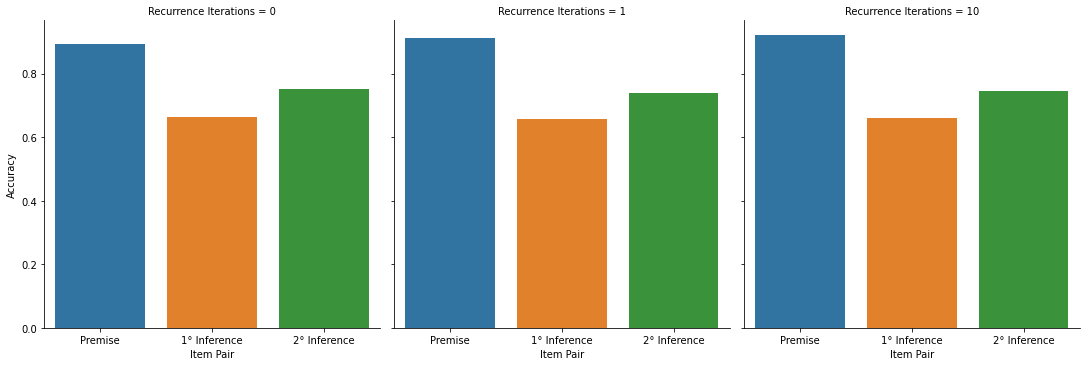

In [9]:
#| code-summary: bar plot visualization of experiment outcome

sns.catplot(x="Item Pair", y="Accuracy", col='Recurrence Iterations', kind='bar', data=result_df)
plt.show()